# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Emotion Recognition using Finetuning BERT </h1></span>

Emotion recognition is a rapidly growing field that has numerous applications in various industries. One of the most popular approaches to emotion recognition is using natural language processing (NLP) techniques, such as sentiment analysis and affective computing. In this article, we'll explore the concept of emotion recognition using NLP and discuss its applications, benefits, and limitations.


[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) is a powerful language model that can be fine-tuned for various natural language processing (NLP) tasks, including sentiment analysis. Compared to traditional machine learning models, BERT has several advantages that make it well-suited for analyzing text data. First, BERT uses a multi-layer bidirectional transformer encoder to generate contextualized representations of words in a sentence, allowing it to capture both local and global dependencies between words. Second, BERT is trained on a large corpus of text data, which means it has learned to represent words in a way that is useful for a wide range of NLP tasks. Third, because BERT is a pre-trained model, it can be easily adapted to new tasks like sentiment analysis by adding a simple output layer on top of the existing model architecture. Overall, using BERT for sentiment analysis can lead to better performance and faster convergence compared to traditional machine learning models.

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Install Required Libraries & Utils Function </h1></span>

In [ ]:
# ====================================================
# Required Libraries
# ====================================================

import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# ====================================================
# Configuration (Hyper Parameters Value)
# ====================================================

class CFG:
    debug=False # want to debug or not 
    apex=True # for faster training
    print_freq=300
    num_workers=4 
    model= 'bert-base-cased' # model name
    epochs=5
    learning_rate=2e-5 
    eps=1e-6
    betas=(0.9, 0.999) # for adam optimizer
    batch_size=32 # batch size
    max_len=512
    weight_decay=0.01 # for adam optimizer regulaization parameter
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['label'] #target columns
    seed=42 # seed no. for random initialization 
    train=True
    num_class = 5 # Number of class in your dataset

In [ ]:
# ====================================================
# Data Loading
# ====================================================

train = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', names=['text', 'emotion'], sep=';')
valid = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', names=['text', 'emotion'], sep=';')
test = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', names=['text', 'emotion'], sep=';')


print(f"train.shape: {train.shape}")
display(train.head())

print(f"valid.shape: {valid.shape}")
display(valid.head())

print(f"test.shape: {test.shape}")
display(test.head())


In [ ]:
print(train["emotion"].unique())
CFG.num_class = train["emotion"].nunique()
print(CFG.num_class)

In [ ]:
# ====================================================
# Label Mapping
# ====================================================

mapping = {'sadness' : 0,
           'anger' : 1,
           'love' : 2,
           'surprise' : 3,
           'fear' : 4,
           'joy' : 5,
          }

train['label'] = train['emotion'].map(mapping)
valid['label'] = valid['emotion'].map(mapping)
test['label'] = test['emotion'].map(mapping)

display(train.head())

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train))
    ax = sns.countplot(x=col,  data=train, order = train[col].value_counts().iloc[:top_x].index) 
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

In [ ]:
countplot(10,5,'emotion',15,45,'Emotion Class','Class Distribution')

In [ ]:
# If Debugging is True then we will consider a small set of training data

if CFG.debug:
    CFG.epochs = 2
    train = train.sample(frac =.25) 

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [ ]:
# ====================================================
# Logger File
# ====================================================

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(CFG.seed)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Tokenizer, Dataset & Collate Function</h1></span>

<font size="3"> In this section, a pretrained tokenizer is loaded to feed the text data into the transformers model. Then it is saved for the future use. Futhermore the value of max_length is calculated by iterating the training text data. </font>

<font size="3"> A dataset with proper format is built to feed the transfomers model. To speed training time, a <code> collate function </code> is used. As Neural Network expects the inputs in a same shape, so we do padding in our text data. Normally, in NLP it is done by <code> padding the text data upto the max_length </code> . But for some short senteces the extra padded token hamper the performance. </font>

<font size="3"> As a result, a collate function is used which <code> padding the text data upto mini-batch max length</code>  not the global max_legnth. So, it gives a boost to the training time. </font>

In [ ]:
# ====================================================
# tokenizer
# ====================================================

tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths = []
tk0 = tqdm(train['text'].fillna("").values, total=len(train))
for text in tk0:
    length = len(tokenizer(text, truncation=True, add_special_tokens=False)['input_ids'])
    lengths.append(length)
    
if max(lengths) + 2 > 512:
    CFG.max_len = 512
else:
    CFG.max_len = max(lengths) + 2 # cls & sep 
LOGGER.info(f"max_len: {CFG.max_len}")

In [ ]:
# ====================================================
# Dataset Preparation
# ====================================================

def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=CFG.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.long)
        return inputs, label
    

# the colllate function to increase training speed

def collate(inputs): 
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Model Architecture </h1></span>

For Finetuning BERT for text classification, the following steps should be followed:

- <b> Input Layer </b>: This layer takes in the input text data, which could be a sequence of words, phrases, or sentences.

- <b> BERT Encoder </b>: This layer applies the BERT encoding to the input text data, generating a sequence of vectors that represent the contextualized embeddings of the input text.

- <b> Pooler </b>: This layer aggregates the vector representation of the input text, usually by taking the mean or sum pooling, to produce a fixed-length vector that captures the overall meaning of the input text. It is very common to use the representation of the [CLS] token as pooling for classification
    
- <b> Classification Head </b>: This layer consists of a fully connected neural network (FCNN) that takes the pooled vector representation as input and produces a probability distribution over the different classes.


## The overall architecture will be: 
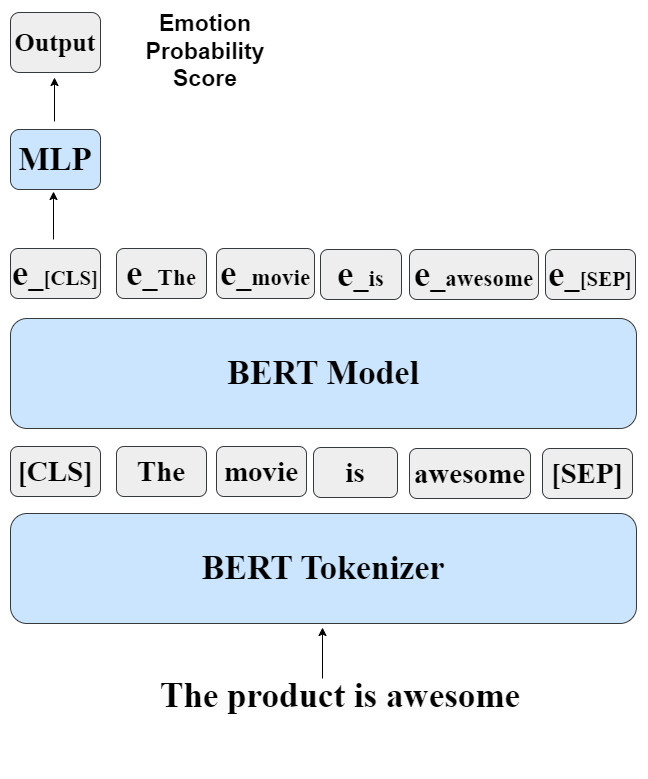

In [ ]:

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True, output_attentions=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
            
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.num_class)


    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs.last_hidden_state # word level representation of last hiddent state
        attentions = outputs.attentions # all layer attention
        
        # pooled sentence representation
        feature = last_hidden_states[:, 0, :] # only  conisdering [CLS] token representations
        
        output = self.fc(feature)
        return output, attentions


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Helpler functions for Training  </h1></span>

<font size="3">Few important function are created here.</font>

1. <i>AverageMeter</i> - To compute & store the average
2. <i>asMinutes</i> - To calculate the time
3. <i>timeSince</i> - To compute training & validation time
4. <i>train_fn</i> - Calculation of forward & backward pass for a single epoch in training data
5. <i>valid_fn</i> - Calculation of forward & backward pass for a single epoch in validation data


In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, device):
    
    # Enabling Model Training Mode
    model.train()
    
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex) # using Automatic Mixed Precision (AMP) for speed up
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    
    for step, (inputs, labels) in enumerate(train_loader): # iterate over the training data 
        inputs = collate(inputs) # the collate function I discussed for speeding up training
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)  # formatting the input to feed into the transformer model 
        labels = labels.to(device) 
        batch_size = labels.size(0)
        
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs) 
            loss = criterion(y_preds.view(-1, CFG.num_class), labels.view(-1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        scaler.scale(loss).backward() # backpropagation
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm) # clipping the gradient
        #scaler.unscale_(optimizer) # this is the change
        
        losses.update(loss.item(), batch_size)
        
        # Updating weights via optimizer & scaler
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
        end = time.time()
        
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm))

    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    
    for step, (inputs, labels) in enumerate(valid_loader): # iterate over the validation data 
        inputs = collate(inputs)
        
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        with torch.no_grad(): # we don't need to store the gradients w.r.t validation data
            y_preds, _ = model(inputs)
            loss = criterion(y_preds.view(-1, CFG.num_class), labels.view(-1))
            
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Training Loop </h1></span>

In [ ]:
from sklearn.metrics import f1_score

def get_score(y_trues, y_preds):
    y_predicted = y_preds.argmax(axis=1)  # Convert probabilities to class predictions
    macro_f1 = f1_score(y_trues, y_predicted, average='macro')
    return macro_f1

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop():

    # ====================================================
    # loader
    # ====================================================
    
    train_dataset = TrainDataset(CFG, train) # training dataset formatting 
    valid_dataset = TrainDataset(CFG, valid) # validation dataset formatting

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True) # train dataloader
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False) # validation dataloader

    valid_labels = valid[CFG.target_cols].values
    
    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)  # initializing the model
    torch.save(model.config, OUTPUT_DIR+'config.pth') # saving the model configuration 
    model.to(device) # GPU Config
    
    optimizer = AdamW(model.parameters(), lr=CFG.learning_rate, eps=CFG.eps, betas=CFG.betas) # declaring the optimizer
    

    criterion = nn.CrossEntropyLoss(reduction="mean")
    best_score = 0

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train function 
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, device)

        # eval function 
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if best_score < score: # Saving the best model w.r.t the score 
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_score{best_score:.4f}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_score{best_score:.4f}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    final_pred = predictions.argmax(axis=1)
    final_pred = final_pred.tolist()
    valid[f"pred_label"] = final_pred

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid, best_score

In [ ]:
# ====================================================
# the training
# ====================================================
    
if __name__ == '__main__':
    
    if CFG.train:
        valid, best_score = train_loop()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center">  Inference </h1></span>


<font color='#3498DB'> <h3> <a id ="section11a"> <b> Configuration for Inference</b> </a> </h3> </font>

<font size="3"> The basic and important configuration for infernce is described here along with some function & other stuff.</font>


In [ ]:
# ====================================================
# CFG for testing
# ====================================================

class CFG_Test:
    num_workers=4
    path="./"
    config_path=path+'config.pth'
    model=CFG.model
    batch_size=CFG.batch_size
    target_cols=CFG.target_cols
    seed=CFG.seed
    num_class = CFG.num_class
    
CFG_Test.tokenizer = AutoTokenizer.from_pretrained(CFG_Test.path+'tokenizer/') # load the saved pretrained tokenizer

In [ ]:
def get_logger(filename='inference'): # infernece logger file
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

<font color='#3498DB'> <h3> <b> Model Loading for Inference</b> </h3> </font>

<font size="3"> Dataset for predicting on the test data and Model Loading for inference are done in this section </font>

In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True)
    
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        return inputs

<font color='#3498DB'> <h3> <b> Prediction on Test Data</b></h3> </font>

<font size="3"> An inference function is made for predicting on the test data. Then finally, loading the previously saved model for each fold and taking prediction on test dataset for each fold. Then, take the average of the each of prediction is considered as model final prediction, </font>

In [ ]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0: # iterate over the test data
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs) # considering the logits only
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import DataCollatorWithPadding
test_dataset = TestDataset(CFG_Test, test)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG_Test.batch_size,
                         shuffle=False,
                         collate_fn=DataCollatorWithPadding(tokenizer=CFG_Test.tokenizer, padding='longest'))
                         

model = CustomModel(CFG_Test, config_path=CFG_Test.config_path, pretrained=False)
state = torch.load(CFG_Test.path+f"{CFG_Test.model.replace('/', '-')}_score{best_score:.4f}_best.pth",
                   map_location=torch.device('cpu')) # loading the saved model

model.load_state_dict(state['model'])
prediction = inference_fn(test_loader, model, device)
del model, state; gc.collect()
torch.cuda.empty_cache()
    


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Evaluation on Test Dataset </h1></span>


In [ ]:
final_prediction = prediction.argmax(axis = 1)
test['Prediction'] = final_prediction
display(test.head())

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report

print('\nThe Classification Report is as follows\n')
print(classification_report(test['label'].tolist(), test['Prediction'].tolist(), digits = 4))

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Model Explainability: Visualization of the Prediction </h1></span>

Explainable artificial intelligence (XAI) is a set of processes and methods that allows human users to comprehend and trust the results and output created by machine learning algorithms. Explainable AI is used to describe an AI model, its expected impact and potential biases. It helps characterize model accuracy, fairness, transparency and outcomes in AI-powered decision making. Explainable AI is crucial for an organization in building trust and confidence when putting AI models into production. AI explainability also helps an organization adopt a responsible approach to AI development.

Two types of explainability can be given. 1. Class Label     2. Word Label

<font color='#3498DB'> <h3>  <b> Class Label Explanation </b> </h3> </font>
Class Label Explanation is simple. I take a sentence, encoded it and feed into the model. Find out the model prediction. Based on the prediction the probable class of the sentence is shown.

<font color='#3498DB'> <h3> <b>Word Label Explanation</b>  </h3> </font>

<font size="3"> Word Label Explanation is much more difficult. The aim is to find the most important word/words which effect the model prediction. It can not be done normally. Different Explainable Alogrithm are introducing to explain this property. The jod of those models is to find the most important parts of the input that are the rationales for the model prediction. Different XAI algo works differently</font>
    
<font size="3"> Among them I used <code>Captum</code> package for model explainablity that is developed by microsoft team. To find most important words for prediction, I use <code>LayerIntegratedGradients</code> algorithm. Integrated gradients is a simple, yet powerful axiomatic attribution method that requires almost no modification of the original network. Layer Integrated Gradients is a variant of Integrated Gradients that assigns an importance score to layer inputs or outputs, depending on whether we attribute to the former or to the latter one. Integrated Gradients is an axiomatic model interpretability algorithm that attributes / assigns an importance score to each input feature by approximating the integral of gradients of the model's output with respect to the inputs along the path (straight line) from given baselines / references to inputs.</font>
    
 <font size="3"> After finding the word importance values, I simply project them on the input sentence via color coding like heatmap. In the color heatmap, the word which will be more <code>closer to Red</code>, has a <code>more importance</code> to make the class prediction


In [ ]:
# installing cptum
!pip install captum

In [ ]:
from transformers.pipelines import TextClassificationPipeline
from captum.attr import LayerIntegratedGradients, TokenReferenceBase
import seaborn as sns
import matplotlib.pyplot as plt

# For HeatMap Visulalization, the color coding
class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255, r, r))
    return 'background-color: %s' % color

# Explainability PipeLine
class ExplainableTransformerPipeline():
    """Wrapper for Captum framework usage with Huggingface Pipeline"""
    
    def __init__(self, name, model, tokenizer, device):
        self.__name = name
        self.model = model
        self.tokenizer = tokenizer
        self.__device = device
    
    def forward_func(self, input_ids, position = 0):
        """
            Wrapper around prediction method of pipeline
        """
        inputs = {
            'input_ids' : input_ids,
            'attention_mask' : torch.ones_like(input_ids)
        }
        pred, _ = self.model(inputs)
        return pred
        
    def visualize(self, inputs_ids, attributes):
        """
            Visualization method.
            Takes list of inputs and correspondent attributs for them to visualize in a barplot
        """
        inputs = inputs_ids
        index = self.tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0])
                                                     
        attr_sum = attributes.sum(-1) 
        
        attr = attr_sum / torch.norm(attr_sum)
        
        data = {
            'words' : index,
            'word_attribution_scores' : attr.numpy()[0],
        }
        df = pd.DataFrame(data)
        display(df)
        char_vals = [CharVal(c, v) for c, v in zip(list(df['words']), list(df['word_attribution_scores']))]
        char_df = pd.DataFrame(char_vals).transpose()
        
        # apply coloring values
        char_df = char_df.style.applymap(color_charvals)
        display(char_df)
                      
    def explain(self, text):
        """
            Main entry method. Passes text through series of transformations and through the model. 
            Calls visualization method.
        """
        inputs = self.generate_inputs(text)
        baseline = self.generate_baseline(sequence_len = inputs.shape[1])
        all_inputs = {
            'input_ids' : inputs,
            'attention_mask' : torch.ones_like(inputs)
        }
        prediction = self.model(all_inputs)
        
        lig = LayerIntegratedGradients(self.forward_func, getattr(self.model, 'model').embeddings)
        
        attributes, delta = lig.attribute(inputs=all_inputs['input_ids'],
                                  baselines=baseline,
                                  target = 0, 
                                  return_convergence_delta = True)
        self.visualize(all_inputs['input_ids'], attributes)
        
    def generate_inputs(self, text):
        """
            Convenience method for generation of input ids as list of torch tensors
        """
        return torch.tensor(self.tokenizer.encode(text, add_special_tokens=False), device = self.__device).unsqueeze(0)
    
    def generate_baseline(self, sequence_len) :
        """
            Convenience method for generation of baseline vector as list of torch tensors
        """        
        return torch.tensor([self.tokenizer.cls_token_id] + [self.tokenizer.pad_token_id] * (sequence_len - 2) + [self.tokenizer.sep_token_id], device = self.__device).unsqueeze(0)


In [ ]:
sample_sentence = test.loc[0, 'text']
print(sample_sentence)

In [ ]:
# Word Level Explainablilty for a sentence

model = CustomModel(CFG_Test, config_path=CFG_Test.config_path, pretrained=False) # loading model for explainability
state = torch.load(CFG_Test.path+f"{CFG_Test.model.replace('/', '-')}_score{best_score:.4f}_best.pth",
                       map_location=torch.device('cpu'))

model.load_state_dict(state['model'])
tokenizer = CFG_Test.tokenizer

device = 'cpu'


exp_model = ExplainableTransformerPipeline('Model For Visualization', model, tokenizer, device)
exp_model.explain(sample_sentence)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Self Attention Visualization  </h1></span>

For <b> Self-Attention </b> visualization, we will use [bertviz](https://github.com/jessevig/bertviz) library. BertViz is an interactive tool for visualizing attention in Transformer language models such as BERT, GPT2, or T5. This tool has two type of visualization 

- **Head View**
- **Model View**

In [ ]:
!pip install bertviz

In [ ]:
from transformers import utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

In [ ]:
input_ids = tokenizer.encode(sample_sentence, return_tensors='pt')  # Tokenize input text
inputs = {
    'input_ids' : input_ids,
    'attention_mask' : torch.ones_like(input_ids)
}
    
predictions, attention = model(inputs) # extracting BERT attention score for visualization
tokens = tokenizer.tokenize(sample_sentence)  # Convert input ids to token strings
tokens.insert(0, "[CLS]")
tokens.append("[SEP]")
print(tokens)

model_view(attention, tokens)  # Display model view

In [ ]:
model_view(attention, tokens, include_layers=[5, 6])

### Head View

In [ ]:
from bertviz import head_view
head_view(attention, tokens)

In [ ]:
head_view(attention, tokens, layer=2, heads=[3,5])

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Highly Attended Tokens  </h1></span>

In this section, our objective is to determine the tokens that receive the highest average self-attention scores across the entire test dataset. Transformers generate an attention score measuring the relationship between **word_i** and **word_j** for every head in every layer. Given **L** different layers and **H** separate heads per layer, the resulting attention matrix assumes a dimensions of **L x H x n x n**, wherein **n** denotes the sequence length.

$$
\text{avg_score}_i = \frac{1}{L \cdot H \cdot n} \sum_{l=1}^{L} \sum_{h=1}^{H} \sum_{t=1 , t!=i}^{n} \text{Attention}_{i, t, h, l}
$$



In [ ]:
def self_attention_vis_for_instance(sen_idx):
    sentence = test.loc[sen_idx, 'text']
    inputs = torch.tensor(CFG.tokenizer.encode(sentence, add_special_tokens=False), device = 'cpu').unsqueeze(0)

    all_inputs = {
            'input_ids' : inputs,
            'attention_mask' : torch.ones_like(inputs)
        }

    predictions, attention = model(all_inputs) 

    #decoding
    index = CFG.tokenizer.convert_ids_to_tokens(inputs.cpu().detach().numpy()[0])

    # Calculate the tokenwise attention

    tokens_avg_attention = []
    num_heads = attention[0][0].size(0)
    token_len = inputs.size(1)

    for i in range(token_len):
        total_attn_i = 0
        for l in range(len(attention)): 
            # batch size, head, n, n but batch_size = 1 in our case
            head_attentions = attention[l][0]  # head, n, n
            # we will not consider the attention of a word itself
            # as we are interested in self_attention with others
            # so, we will omit self_attention(word_i, word_i)
            total_attn_i += torch.sum(head_attentions[:, i, :]) - torch.sum(head_attentions[:, i, i])

        avg_attn_i = total_attn_i / (l * num_heads * token_len)
        tokens_avg_attention.append(avg_attn_i.item())

    data = {
        'words' : index,
        'attentions' : tokens_avg_attention,
    }
    
    explain_df = pd.DataFrame(data)
    
    return explain_df

In [ ]:
df = self_attention_vis_for_instance(0)
df

In [ ]:
from collections import defaultdict

attention_scores_of_tokens = defaultdict(list)

index = list(test.index)
for idx in tqdm(index):
    explain_df = self_attention_vis_for_instance(idx)
    token_ls = list(explain_df['words'])
    attention_scores = list(explain_df['attentions'])
    
    for i, token in enumerate(token_ls):
        attention_scores_of_tokens[token].append(attention_scores[i])
        
        
print(len(attention_scores_of_tokens))

In [ ]:
avg_attn_scores_of_tokens = dict()

for key, value in attention_scores_of_tokens.items():
    avg_attn_scores_of_tokens[key] = sum(value) / len(value)
    
print(len(avg_attn_scores_of_tokens))

In [ ]:
final_df = pd.DataFrame(list(avg_attn_scores_of_tokens.items()), columns=['Words', 'Avg_Attention'])
final_df.head()

In [ ]:
def get_high_and_low_attentive_token(dataframe, top = 20):
    sorted_df = dataframe.sort_values(['Avg_Attention', 'Words'], ascending = False)
    
    highly_attn = sorted_df.head(top)
    lowly_attn = sorted_df.tail(top)
    
    return highly_attn, lowly_attn

In [ ]:
highly_attn, lowly_attn = get_high_and_low_attentive_token(final_df)

print("Higly Attentive: ")
display(highly_attn.transpose())
print("\nLowly Attentive: ")
display(lowly_attn.transpose())

## Point to be Noted

If we find highly/lowly attentive tokens for the overall the dataset, it may not be that much useful. But if we find classwise highly/lowly attentive tokens, we can dig deeper into more explanation. For example, for emotion class **sadness**, if we find highly/lowly attentive tokens, we can explain better. 

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Thanks for Reading </h1></span>